In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training_demo import MCEM_demo, MCEM_windows_demo, MCEM_sampler_demo, MCEM_Q_maximizer_demo

from matplotlib import pyplot as plt

In [3]:
def get_square_data(num_training, num_testing, std_noise=0.01):
    num_low = num_training // 2
    num_high = num_training - num_low
    X_train = np.vstack((np.linspace(-1.5, -0.5, num_low//2)[:, np.newaxis],
                         np.linspace(-0.45, 0.45, num_high)[:, np.newaxis], 
                         np.linspace(0.5, 1.5, num_low - num_low//2)[:, np.newaxis]))
    y = np.vstack((np.zeros((num_low//2, 1)), np.ones((num_high,1)),
                   np.zeros((num_low-num_low//2,1))))
    scale = np.sqrt(y.var())
    offset = y.mean()
    Y_train = (y-offset)/scale

    X_test = np.linspace(-3., 3., num_testing)[:, None]
    Y_test = []
    for x in X_test[:,0]:
        if x > -0.5 and x < 0.5:
            y = 1.
        else:
            y = 0.
        Y_test.append(y)
    Y_test = np.array(Y_test)[:, np.newaxis]
    Y_test = (Y_test - offset)/scale
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_training, num_testing, batch_size, std_noise=0.01):
    X_train, Y_train, X_test, Y_test= get_square_data(num_training, num_testing, std_noise=std_noise)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(batch_size) # try not to use full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

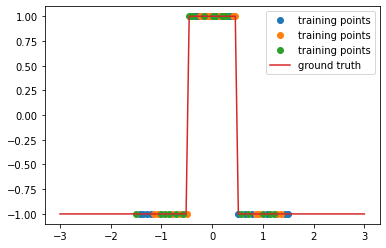

In [4]:
num_training = 60
batch_size = 20
num_testing = 100
std_noise = 0.1

ds_train, ds_test, X_test = load_demo_data(num_training, num_testing, batch_size, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')
plt.legend()
# plt.savefig('square.png')

# 2-layer DGPs (MCEM with Moving Windows)

In [5]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF' for _ in range(2)], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [6]:
model.Omega_hyperparams

2022-08-25 12:58:26.605413: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [7]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.9, resample_in_cycle_head=False,
                               start_sampling_epoch=300, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.9, resample_in_cycle_head=False,
                                         start_sampling_epoch=300, epochs_per_cycle=100)

In [9]:
# MCEM with Moving Windows settings and training
total_EM_steps = 500
_, _, lines, W = MCEM_windows_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                              window_size=200,
                              num_samples_fixing_hyper=500,
                              print_epoch_cycle_EM=300, print_epoch_cycle_fixing=500)

############### EM step 1 of total 500 steps. E Step:  ###############


2022-08-25 13:02:20.494200: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-25 13:02:21.063211: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-25 13:02:21.063275: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Sampling Epoch: 299
Mean Log Likelihood -- train: -1.3951367139816284, -- test: 0.37752464413642883 
Root Mean Squared Error -- train: 0.2357449233531952, -- test: 0.14185358583927155 

#################### Sample No.1 at Epoch 349  lr = 1.2021529605110715e-10 ####################
********************  End of Sampling  ********************
Number of sampled models: 1 
Test Log Likelihood of all sampled models: 0.5541391968727112
Test Root MSE of all sampled models: 0.12880274653434753
********************************************************************** 

********************  End of E step  ********************
Number of all sampled models in window: 1 
Test Log Likelihood of all models in window: 0.5541391968727112
Test Root MSE of all models in window: 0.12880274653434753

############### EM step 1 of total 500 steps, M Step:  ###############
**********************************************************************
Q function is 0.08622753620147705 averaged by 1 samples.
*************

2022-08-25 13:33:22.452150: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


Sampling Epoch: 299
Mean Log Likelihood -- train: 0.35871803760528564, -- test: 0.6722924709320068 
Root Mean Squared Error -- train: 0.16820065677165985, -- test: 0.11325110495090485 

#################### Sample No.1 at Epoch 349  lr = 1.2021529605110715e-10 ####################
********************  End of Sampling  ********************
Number of sampled models: 1 
Test Log Likelihood of all sampled models: 0.3242977261543274
Test Root MSE of all sampled models: 0.17317357659339905
********************************************************************** 

********************  End of E step  ********************
Number of all sampled models in window: 199 
Test Log Likelihood of all models in window: 0.5781979560852051
Test Root MSE of all models in window: 0.22089245915412903

############### EM step 204 of total 500 steps, M Step:  ###############
**********************************************************************
Q function is 0.29679542779922485 averaged by 1 samples.
*********

In [10]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.21491478>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.4042876], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=-0.088085145>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.21493812], dtype=float32)>]

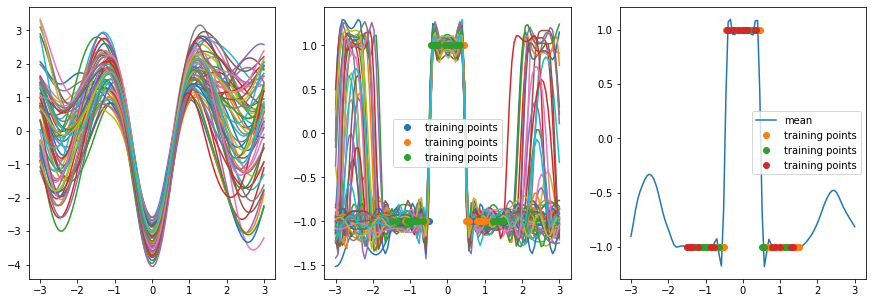

In [11]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[:60]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[:64]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('2layer-sin.png')